# Custom network simplification

Manually configure network simplification steps and parameters.

Network simplification helps to prevent distortions in centrality measures and can also be preferable for visualisation.

While cleaning and simplifying the network, `cityseer` keeps track of intersection coordinates and street geometries and updates these in place, checking that the street alignments remain as accurate as possible. This is a complex undertaking that involves finding an approach that works as well as possible for most situations. Manual inspection and cleaning is recommended as a final step for best results.


In [2]:
from cityseer.tools import graphs, plot, io

The test area is taken from London Soho.


In [3]:
lng, lat = -0.13396079424572427, 51.51371088849723
buffer = 1200
poly_wgs, epsg_code = io.buffered_point_poly(lng, lat, buffer)


### Option 1 - Automatic simplification

Simplification is automatic when using the [`osm_graph_from_poly`](https://cityseer.benchmarkurbanism.com/tools/io#osm-graph-from-poly) function.


INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
INFO:cityseer.tools.io:Converting networkX graph to CRS code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.graphs:Removing dangling nodes.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Splitting opposing edges.
INFO:cityseer.tools.graphs:Squashing opposing nodes
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Splitting opposing edges.
INFO:cityseer.tools.graphs:Squashing opposing nodes
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
INFO:cityseer.tools.util:Creating 

MultiGraph with 1265 nodes and 1971 edges


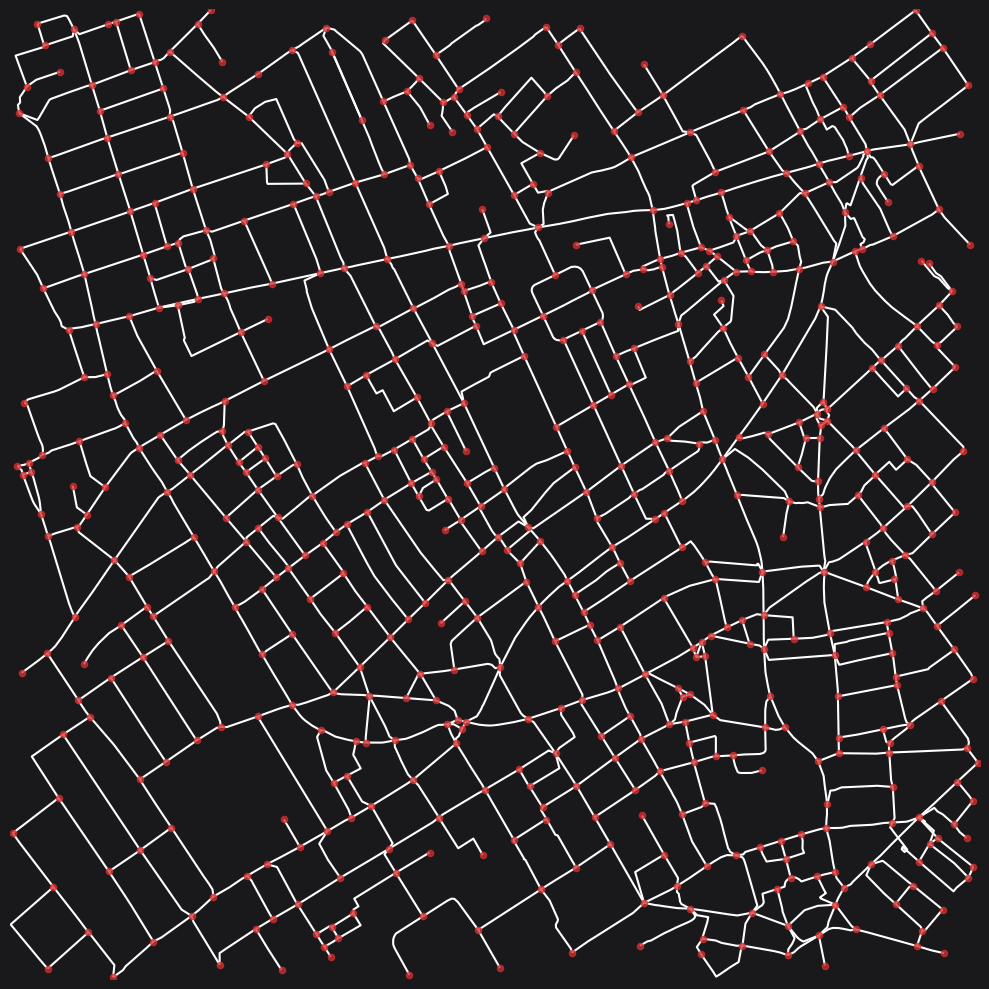

In [4]:
G_auto = io.osm_graph_from_poly(poly_wgs, simplify=True)
print(G_auto)
plot.plot_nx(
    G_auto,
    plot_geoms=True,
    figsize=(10, 10),
    x_lim=(698173, 699570),
    y_lim=(5710085, 5711440),
)

### Option 2 - Automatic simplification with custom parameters

[`osm_graph_from_poly`](https://cityseer.benchmarkurbanism.com/tools/io#osm-graph-from-poly) accepts parameters which offer a certain amount of control over the simplification process. Altering the distances used for `final_clean_distances` will affect how aggressive the final round of network simplification is. The default is `(5, 10)`. So, for example, adding `20` will make the simplification more aggressive.

Footways and service roads intersecting green spaces are removed by default. This can be changed by setting `green_footways` and `green_service_roads` to `True`.

`cycleways` is set to `True` by default because they sometimes provide important links within networks.

The below example uses more aggressive cleaning while not discarding green footways.


INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
INFO:cityseer.tools.io:Converting networkX graph to CRS code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.graphs:Removing dangling nodes.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Splitting opposing edges.
INFO:cityseer.tools.graphs:Squashing opposing nodes
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Splitting opposing edges.
INFO:cityseer.tools.graphs:Squashing opposing nodes
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
INFO:cityseer.tools.util:Creating 

MultiGraph with 1091 nodes and 1804 edges


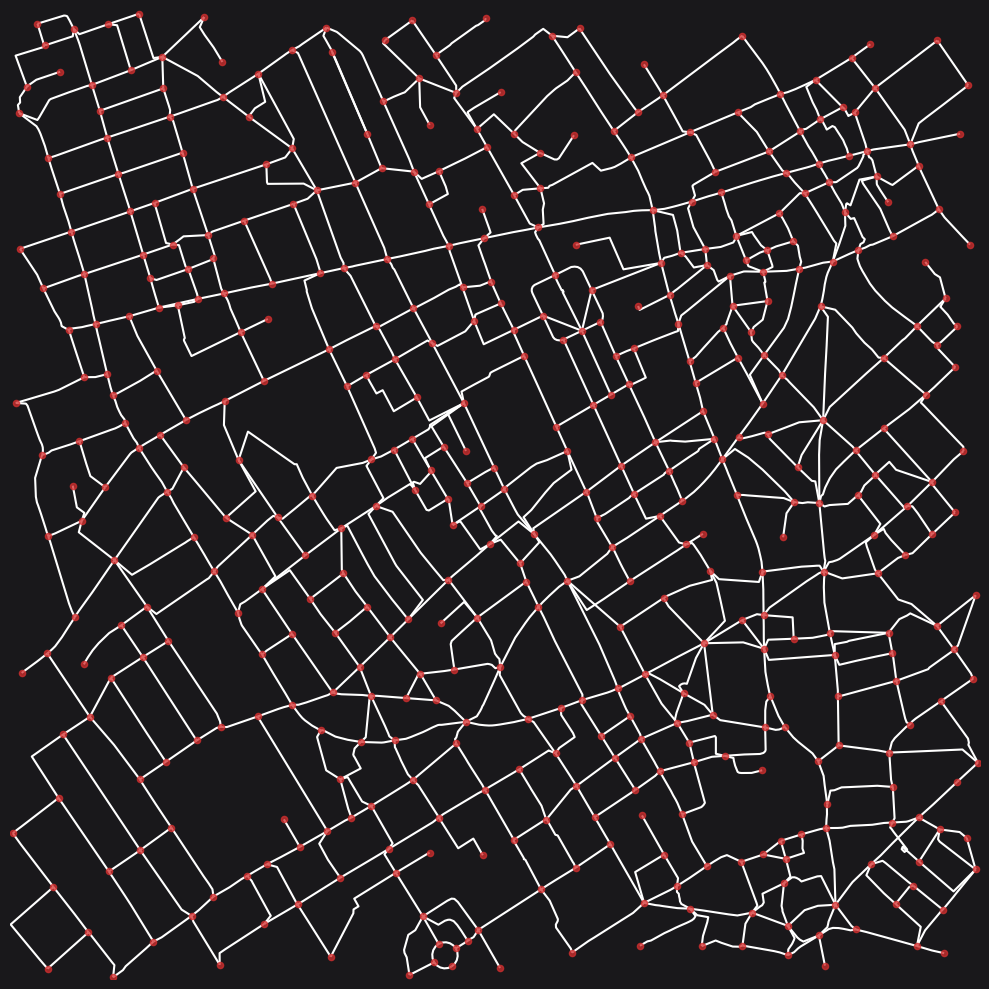

In [6]:
G_params = io.osm_graph_from_poly(
    poly_wgs,
    simplify=True,
    final_clean_distances=(5, 10, 25),  # adds 20
    remove_disconnected=100,
    cycleways=True,
    busways=False,
    green_footways=True,  # keeps
    green_service_roads=False,
)
print(G_params)
plot.plot_nx(
    G_params,
    plot_geoms=True,
    figsize=(10, 10),
    x_lim=(698173, 699570),
    y_lim=(5710085, 5711440),
)

### Option 3 - Custom OSM requests

You may want more control over the data request that is sent internally to the OSM Overpass API. This is possible by providing the `custom_request` argument. The [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL) is useful for figuring out which tags you may want to include or exclude in your request.

Note that the custom request must include a `{geom_osm}` placeholder, which will be replaced internally with the geometry of the area you are requesting data for.


INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
INFO:cityseer.tools.io:Converting networkX graph to CRS code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.graphs:Removing dangling nodes.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Splitting opposing edges.
INFO:cityseer.tools.graphs:Squashing opposing nodes
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Splitting opposing edges.
INFO:cityseer.tools.graphs:Squashing opposing nodes
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
INFO:cityseer.tools.util:Creating 

MultiGraph with 1265 nodes and 1971 edges


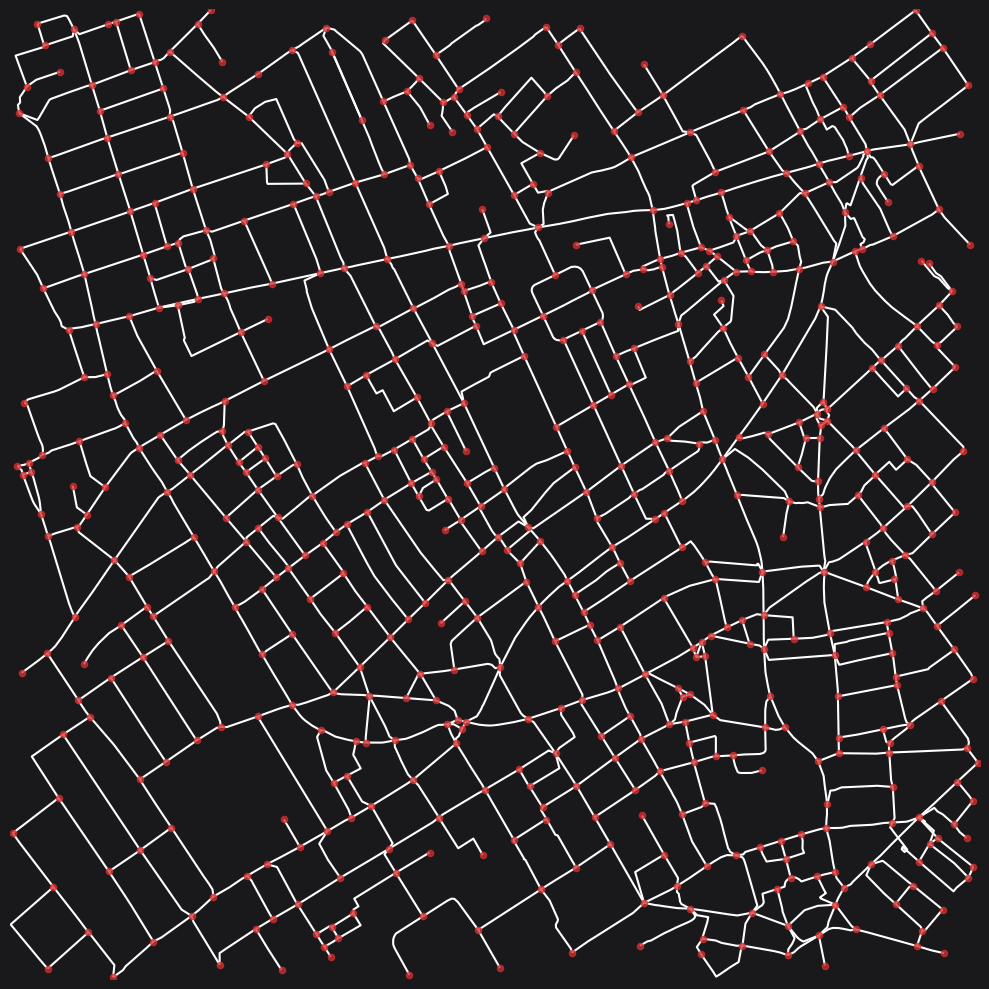

In [7]:
req = """
    [out:json];
    (way["highway"]
        ["highway"!~"bus_guideway|busway|escape|raceway|proposed|planned|abandoned|platform|
            emergency_bay|rest_area|disused|corridor|ladder|bus_stop|elevator|services"]
        ["area"!="yes"]
        ["footway"!="sidewalk"]
        ["amenity"!~"charging_station|parking|fuel|motorcycle_parking|parking_entrance|parking_space"]
        ["indoor"!="yes"]
        ["level"!="-2"]
        ["level"!="-3"]
        ["level"!="-4"]
        ["level"!="-5"](poly:"{geom_osm}");
    );
    out body;
    >;
    out qt;
"""
G_req = io.osm_graph_from_poly(poly_wgs, simplify=True, custom_request=req)
print(G_req)
plot.plot_nx(
    G_req,
    plot_geoms=True,
    figsize=(10, 10),
    x_lim=(698173, 699570),
    y_lim=(5710085, 5711440),
)

### Option 4 - Manual simplification

If you need full control over the simplification process, you can use the following as a template for further configuring your cleaning recipe. This offers a large degree of control, but he precise combination of tags and distances involves a degree of experimentation and some inevitable trade-offs for a given area of interest.

For this approach, start with an unsimplified network, which will perform only rudimentary preparation.


INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
INFO:cityseer.tools.io:Converting networkX graph to CRS code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges


MultiGraph with 7428 nodes and 8562 edges


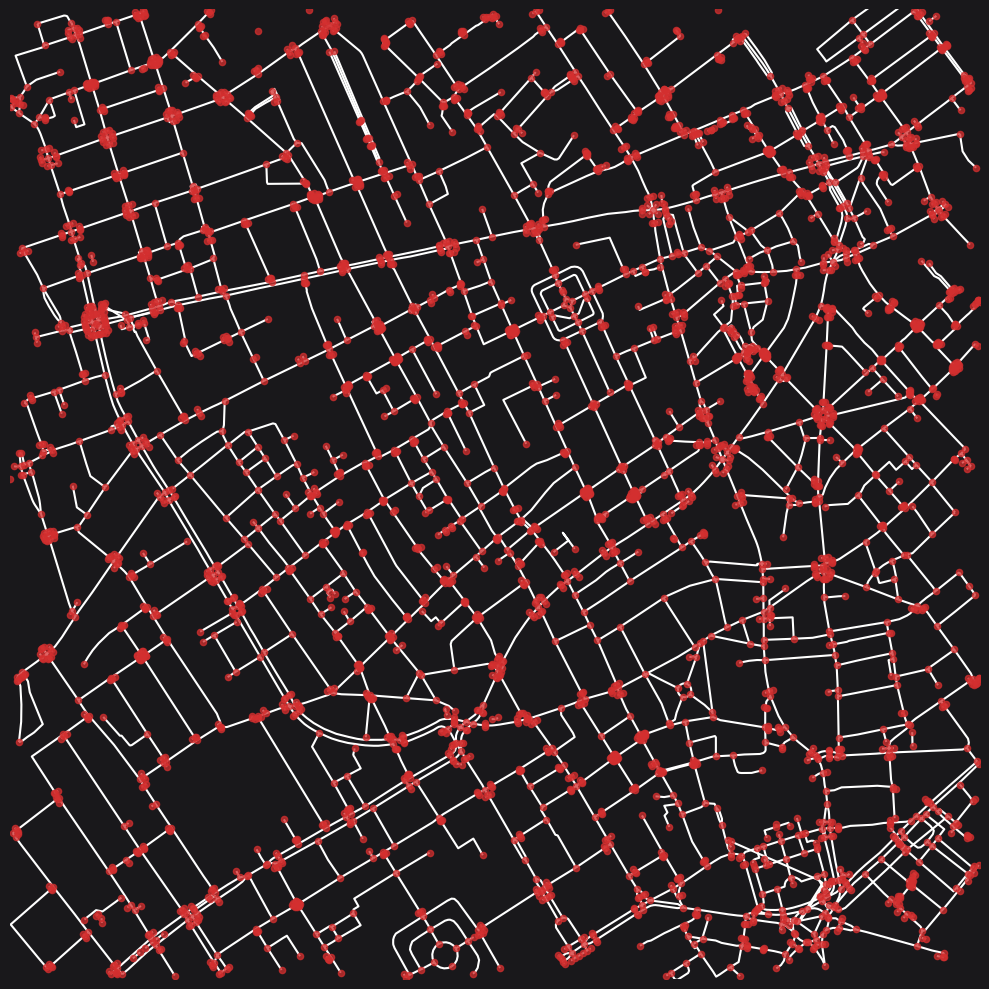

In [8]:
G_raw = io.osm_graph_from_poly(poly_wgs, simplify=False)
print(G_raw)
plot.plot_nx(
    G_raw,
    plot_geoms=True,
    figsize=(10, 10),
    x_lim=(698173, 699570),
    y_lim=(5710085, 5711440),
)

Then manipulate the network depending on your needs. See the [`graphs`](https://cityseer.benchmarkurbanism.com/tools/graphs) module for further information what the various functions do.


In [ ]:
from cityseer import config

# It is recommended to override validation during cleaning
# This spares unnecessary repetition of validation checks
config.SKIP_VALIDATION = True

# deduplicate by hierarchy
G = graphs.nx_deduplicate_edges(G_raw, dissolve_distance=20, max_ang_diff=20)
# remove disconnected components
G = graphs.nx_remove_dangling_nodes(G, despine=0, remove_disconnected=100)
# clean by highway types - leave motorways alone
# split only for a given type at a time
for dist, tags, max_angle in (
    (28, ["trunk"], 45),
    (24, ["primary"], 45),
    (20, ["secondary"], 45),
    (16, ["tertiary"], 45),
):
    G = graphs.nx_split_opposing_geoms(
        G,
        buffer_dist=dist,
        squash_nodes=True,
        centroid_by_itx=True,
        osm_hwy_target_tags=tags,
        osm_matched_tags_only=True,
        prioritise_by_hwy_tag=True,
        simplify_by_max_angle=max_angle,
    )
# consolidate
for dist, tags, max_angle in (
    (28, ["trunk"], 95),
    (24, ["trunk", "primary"], 95),
    (20, ["trunk", "primary", "secondary"], 95),
    (16, ["trunk", "primary", "secondary", "tertiary"], 95),
):
    G = graphs.nx_consolidate_nodes(
        G,
        buffer_dist=dist,
        crawl=False,
        centroid_by_itx=True,
        osm_hwy_target_tags=tags,
        osm_matched_tags_only=True,
        prioritise_by_hwy_tag=True,
        simplify_by_max_angle=max_angle,
    )
    G = graphs.nx_remove_filler_nodes(G)
# snap gapped endings - don't clean danglers before this
G = graphs.nx_snap_gapped_endings(
    G,
    osm_hwy_target_tags=[
        "residential",
        "living_street",
        # "service", # intentionally omitted - e.g. parking lots
        "cycleway",
        "bridleway",
        "pedestrian",
        "steps",
        "footway",
        "footway_green",
        "footway_pedestrian",  # plazas
        "path",
    ],
    buffer_dist=20,
)
# snap gapped endings to roads - don't clean danglers before this
# look for degree 1 dead-ends and link to nearby edges
G = graphs.nx_split_opposing_geoms(
    G,
    buffer_dist=20,
    osm_hwy_target_tags=[
        # "trunk",  # intentionally omitted
        "primary",
        "primary_link",
        "secondary",
        "secondary_link",
        "tertiary",
        "tertiary_link",
        "residential",
        "living_street",
        # "service", # intentionally omitted - e.g. parking lots
        "cycleway",
        "bridleway",
        "pedestrian",
        "steps",
        "footway",
        "footway_green",
        "footway_pedestrian",  # plazas
        "path",
    ],
    min_node_degree=1,
    max_node_degree=1,
    squash_nodes=False,
)
# remove danglers
G = graphs.nx_remove_dangling_nodes(G, despine=40)
# do smaller scale cleaning
max_angle = 120  # rue de nevers in Paris
for dist in (5, 10):
    G = graphs.nx_split_opposing_geoms(
        G,
        buffer_dist=dist,
        squash_nodes=True,
        centroid_by_itx=True,
        osm_hwy_target_tags=[
            # "trunk",  # intentionally omitted
            "primary",
            "primary_link",
            "secondary",
            "secondary_link",
            "tertiary",
            "tertiary_link",
            "residential",
            "living_street",
            "service",
            "cycleway",
            "bridleway",
            "pedestrian",
            # "steps",
            "footway",
            "footway_pedestrian",  # plazas
            "path",
            "unclassified",
        ],
        prioritise_by_hwy_tag=True,
        simplify_by_max_angle=max_angle,
    )
    G = graphs.nx_consolidate_nodes(
        G,
        buffer_dist=dist,
        crawl=True,
        centroid_by_itx=True,
        osm_hwy_target_tags=[
            "trunk",
            "trunk_link",
            "primary",
            "primary_link",
            "secondary",
            "secondary_link",
            "tertiary",
            "tertiary_link",
            "residential",
            "living_street",
            "service",
            "cycleway",
            "bridleway",
            "pedestrian",
            "steps",
            "footway",
            "footway_pedestrian",  # plazas
            "path",
            "unclassified",
        ],
        prioritise_by_hwy_tag=True,
        simplify_by_max_angle=max_angle,
    )
G = graphs.nx_remove_filler_nodes(G)
G = graphs.nx_merge_parallel_edges(
    G, merge_edges_by_midline=True, contains_buffer_dist=50
)
G = graphs.nx_iron_edges(G, min_self_loop_length=100, max_foot_tunnel_length=100)
# do this last to clean up any orphaned sub components
G = graphs.nx_remove_dangling_nodes(G, despine=25)


INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.graphs:Removing dangling nodes.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Splitting opposing edges.
INFO:cityseer.tools.graphs:Squashing opposing nodes
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Splitting opposing edges.
INFO:cityseer.tools.graphs:Squashing opposing nodes
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Splitting opposing edges.
INFO:cityseer.tools.graphs:Squashing opposing nodes
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Splitting opposing edges.
INFO:cityseer.too

INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges


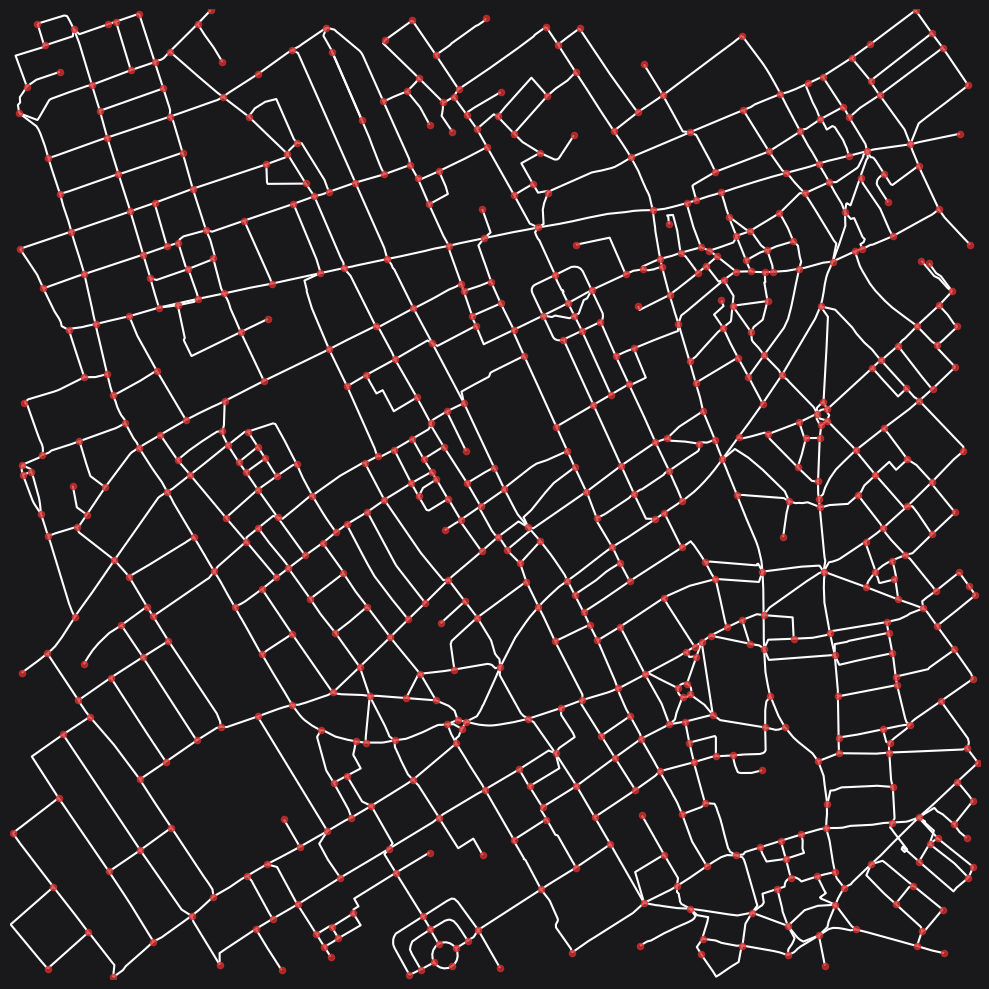

In [10]:
plot.plot_nx(
    G,
    plot_geoms=True,
    figsize=(10, 10),
    x_lim=(698173, 699570),
    y_lim=(5710085, 5711440),
)